In [1]:
# This will be based on MLP but more towards how we optimize training 


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [60]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) *0.2 #* (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # fix initialization, why not zero ? 
b2 = torch.randn(vocab_size,                      generator=g) * 0 # fix initialization to minimize logits value

# BatchNorm parameters
# bngain = torch.ones((1, n_hidden))
# bnbias = torch.zeros((1, n_hidden))
# bnmean_running = torch.zeros((1, n_hidden))
# bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1,b1, W2, b2] #, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [61]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors, this is gaussian 
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation, want close to zero 
#   # BatchNorm layer
#   # -------------------------------------------------------------
#   bnmeani = hpreact.mean(0, keepdim=True)
#   bnstdi = hpreact.std(0, keepdim=True)
#   hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
#   with torch.no_grad():
#     bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
#     bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
#   # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
#   print(logits)
#   break  
  

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


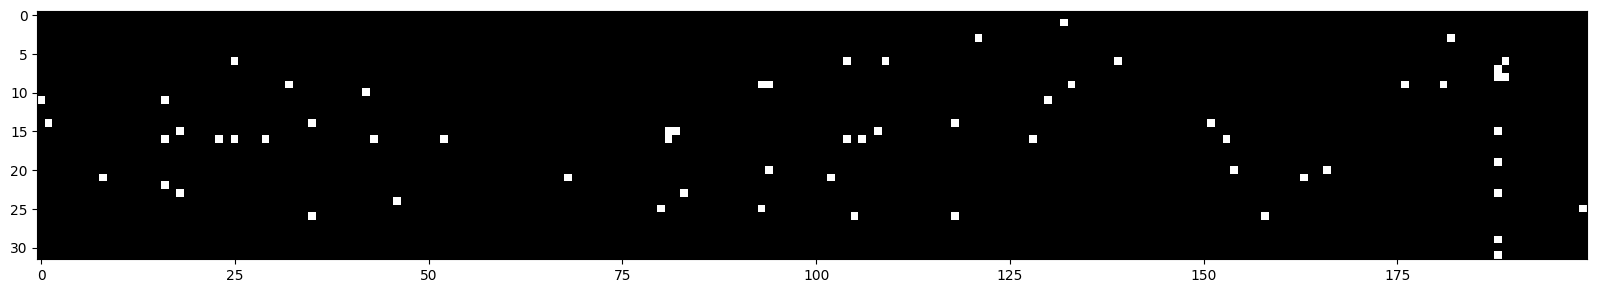

In [55]:
# black 0 and white 1 for h, white places all neuron will be destroyed
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# if column is white then nothing is passing by 

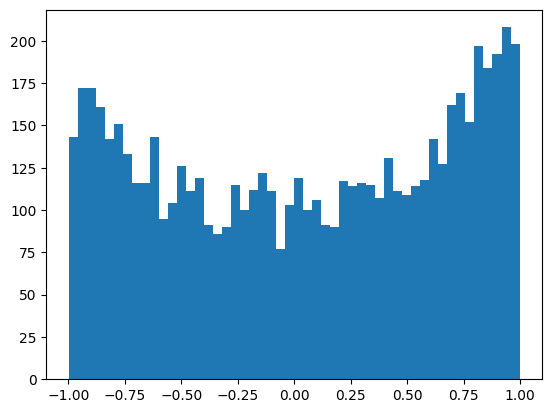

In [56]:
plt.hist(h.view(-1).tolist(), 50); # value of h passed to tanh so majority of it should not be close to 1,-1

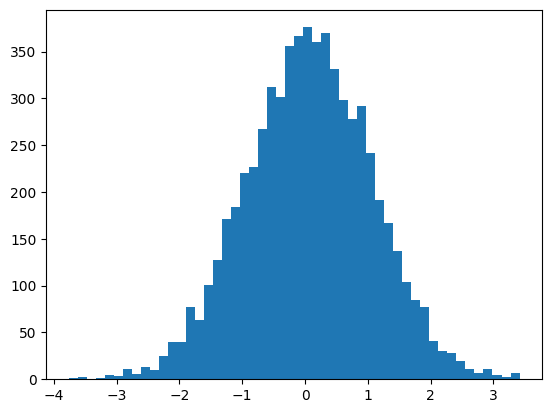

In [57]:
plt.hist(hpreact.view(-1).tolist(), 50); # this is being passed to tanh, so higher value will result into 1 or -1
# ti fix this we want it to close to uniform distribution with mean 0 and variance 1.

In [64]:
# ## loss log

# ### original:
# train 2.1245384216308594
# val   2.168196439743042

# ### fix softmax confidently wrong: (W2, B2)
# train 2.07
# val   2.13

# ### fix tanh layer too saturated at init: (W1, B1)
# train 2.0355966091156006
# val   2.1026785373687744

# ### use semi-principled "kaiming init" instead of hacky init:
# train 2.0376641750335693
# val   2.106989622116089

# ### add batch norm layer
# train 2.0668270587921143
# val 2.104844808578491

In [58]:
# Notes the first thing to pay attentions is initialization 
# Initial loss should have been 1/27, uniform distribution 
-torch.log(torch.tensor(1/27.0))

tensor(3.2958)

In [59]:
# 4 dimensions example of the issue, so basically during initialization 
# logits is taking exterme value 
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print(probs, loss)

logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print(probs, loss) # low loss

logits = torch.tensor([100.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print(probs, loss) # high loss


logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print(probs, loss) # high loss

tensor([0.2500, 0.2500, 0.2500, 0.2500]) tensor(1.3863)
tensor([0.0066, 0.0066, 0.9802, 0.0066]) tensor(0.0200)
tensor([1.0000e+00, 3.7835e-44, 5.5211e-42, 3.7835e-44]) tensor(95.0000)
tensor([0.4808, 0.0882, 0.4019, 0.0291]) tensor(0.9115)


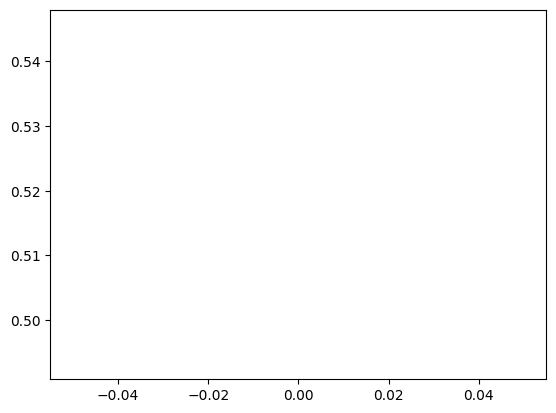

In [52]:
plt.plot(lossi)

In [12]:
# # calibrate the batch norm at the end of training

# with torch.no_grad():
#   # pass the training set through
#   emb = C[Xtr]
#   embcat = emb.view(emb.shape[0], -1)
#   hpreact = embcat @ W1 # + b1
#   # measure the mean/std over the entire training set
#   bnmean = hpreact.mean(0, keepdim=True)
#   bnstd = hpreact.std(0, keepdim=True)


In [32]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1  + b1)
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  #hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0695769786834717
val 2.131199836730957


In [14]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))
    

rrnhvvyhcyysewgfy.
rrnhvqbgcdyhddrshcjkhgkbdnrzothslrhcgfy.
.
rrnhvqbgsewgmtiofvyrhguyozvwucovwidtesjrhguyozvwucovwthslrindiedixjy.
rrnhvqbgsexjkcynsrqhs.
.
hlcbyhidigdyxzvkhhjkdixjyrhguyozvwucovwths.
rrnhvqbgsewgmtiofvwths.
.
rrnhodydddddddddddxshvyyhodydiejoyhshodydiediddxshvyyhjkdgxyyoadiddxshvyyhjkdixjyrhguyozvwucovwthslkdaadjdyhdyrzgthxjy.
rrnhodydzshvyyhodyddddddddxewaesyxshvyycoewidigdyxzvkhhjkyixfkcovwidtesjrhguyozvwucovwthslrhcgfy.
.
rrnhvqbgxdyrzucovwidtesjrhguyozvyycbyhidigdyxzvkhhdirzoahodydiedixjyrnnxvymhjkdokhdneslkdjxvccvnhguyozvyyhodydiddxshvyyhadiddxshvyyhjkigkhynguhddrzvwuhjryhcyysewylsouhjryhouyhouyhodydiediejoyhshwjwtesjrhguyozvwucovwixtyxfvwthslrhcgfy.
.
rrnhvqbgsexjkcynsrqhs.
.
.
rrnhvvyhcyysewgmtiofvyrhgtbxjyrnuodrewaesyxshvyyhjkdixjyrhgtfxjkcynsrnshxjyrhgcbyhidigdyxzvkhhoyy.
.
rrnhvvyhcyysewgmtiofvwovsvcvxhczyikkoon.


In [15]:
# Notes the first thing to pay attentions is initialization 
# Initial loss should have been 1/27, uniform distribution 
# First thing: Fix logits value to be uniform and small
# second thing: Value of h which gets passed to tanh (-1, 1) at the edge the slope is 0
#             This is dead neuron
#.          basically tanh backward will be zero if tanh ~= 1 or -1 , flat region
# if tanh =0 then gradient will just pass through 
# so if tanh=1 or -1 (dead neuron) or if tanh = 0 then gradient will be just pass by
# so. we want some entropy so tanh should not be -1, 1 or 0
# apart from flat region, a high learning rate can also caused the too much gradient and then it gets knocked out
# During Initializaion it can also 
# so question is why do you use a function with flat tails ? 
